In [1]:
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
import sys
from collections import Counter
import pandas as pd
import matplotlib.patches as patches
import seaborn as sns
import copy
import torch
import os
import xmltodict
from dotmap import DotMap
import seaborn as sns

In [2]:
sys.path.append("..")
from notebooks.utils import get_item, get_image_info
from src.data.data_loader import CreateDataLoader

In [3]:
d_opt = DotMap({
    "dataset": "AI4EU",
    "annotators": None,
    "annotator_draw": 0,
    "split_path": '../data/splits/split3.json',
    "labels_dir": '../data/all_labels',
    "images_dir": '../data/complete_dataset',
    "phase": 'all',
    "nThreads": 0,
    "step_batch_size": 2
})

In [4]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('GPU')
else:
    device = torch.device('cpu')
    print('CPU')

GPU


In [5]:
data_holder = CreateDataLoader(d_opt)

CustomDatasetDataLoader
dataset [AI4EU] was created


In [6]:
data = []
for i in range(len(data_holder)):
    im_info = get_image_info(d_opt.labels_dir, data_holder.dataset.ids[i]).reset_index().rename({"index": "box_idx"},axis=1)
    data.append(im_info)
data = pd.concat(data)
data["image_id"] = data["image_id"].astype(str)
data["w"] = data["xmax"] - data["xmin"]
data["h"] = data["ymax"] - data["ymin"]
data["area"] = data["w"] * data["h"]
data.head()

,box_idx,image_id,annotator,xmin,ymin,xmax,ymax,w,h,area
0,0,1597908100538,5,240,2470,341,2606,101,136,13736
1,1,1597908100538,5,1,2314,179,2460,178,146,25988
2,2,1597908100538,5,268,2070,427,2238,159,168,26712
3,3,1597908100538,5,435,2021,549,2089,114,68,7752
4,4,1597908100538,5,554,1870,705,1975,151,105,15855


In [7]:
a=data[["image_id", "annotator"]].drop_duplicates().groupby("image_id").apply(lambda v: v.iloc[0]).groupby("annotator").size()

In [8]:
import json
with open(d_opt.split_path, 'r') as fd:
    split_data = json.load(fd)

In [9]:
annotators = ["0", "4", "5", "6"]
splits = ["train", "val", "test"]
df=[]
for ann in annotators:
    row = []
    for split in splits:
        if ann != "0":
            n = len(set(split_data[ann][split]) - set(split_data["0"][split]))
        else:
            n = len(set(split_data[ann][split]))
        row.append(n)
    df.append(row)

In [10]:
df = []
for ann in annotators:
    df.append([])
    for i_r, split in enumerate(splits):
        acum = 0
        for image_id in split_data[ann][split]:
            if ann != "0" and image_id in set(data[data.annotator == 0].image_id.values):
                continue
            acum += sum((data.annotator == int(ann)) & (image_id == data.image_id))
        df[-1].append(acum)

In [11]:
df = pd.DataFrame(df, columns=["Train", "Validation", "Test"], index=annotators)
df["Total"] = df.sum(axis=1)
df.loc["Total",:] = df.sum(axis=0)
df = df.astype(int)
df

,Train,Validation,Test,Total
0,527,115,112,754
4,405,86,40,531
5,361,74,57,492
6,482,57,100,639
Total,1775,332,309,2416


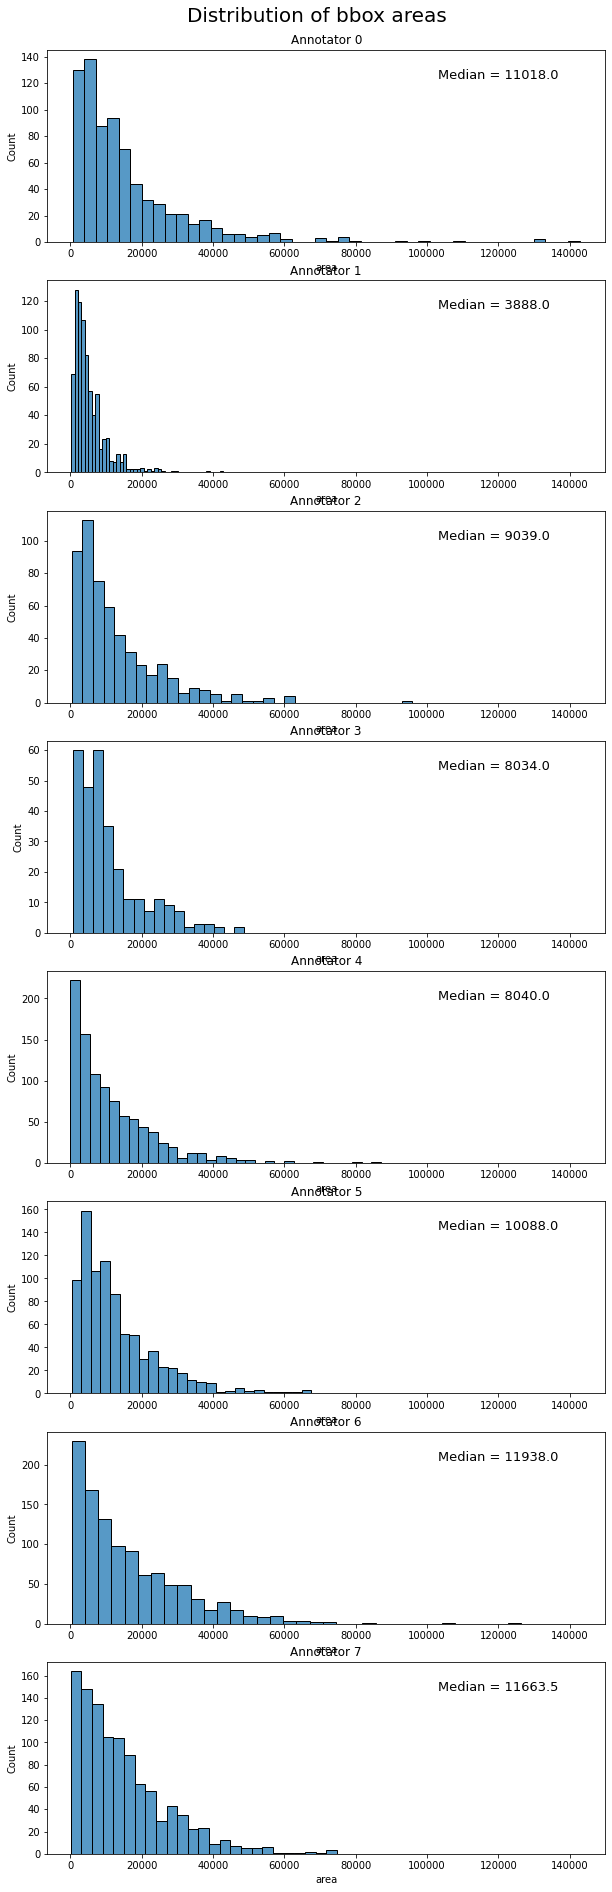

In [12]:
fig, ax = plt.subplots(8, figsize=(10,30))
plt.suptitle('Distribution of bbox areas',fontsize=20)
x = np.arange(0,1,0.05)
for ann in range(8):
    ax[ann].set_title(f'Annotator {ann}')
    areas_bbox = data[data["annotator"] == ann]["area"]
    sns.histplot(areas_bbox, ax=ax[ann])
    ax[ann].annotate(f"Median = {round(areas_bbox.median(),2)}", xy=(0.6,0.85), xytext=(0.7, 0.85), textcoords='axes fraction',fontsize=13)
for ax_i in ax:
    ax_i.sharex(ax[0])
fig.subplots_adjust(top=0.96)
plt.show()

In [13]:
data = data[~data.annotator.isin([1,2,3,7])]

In [14]:
import random
random.seed(1)
# Sample one annotator for pictures with more than one annotator
data = data.groupby("image_id").apply(lambda d: d[d["annotator"] == random.choice(d["annotator"].values)]).reset_index(level=0,drop=True)

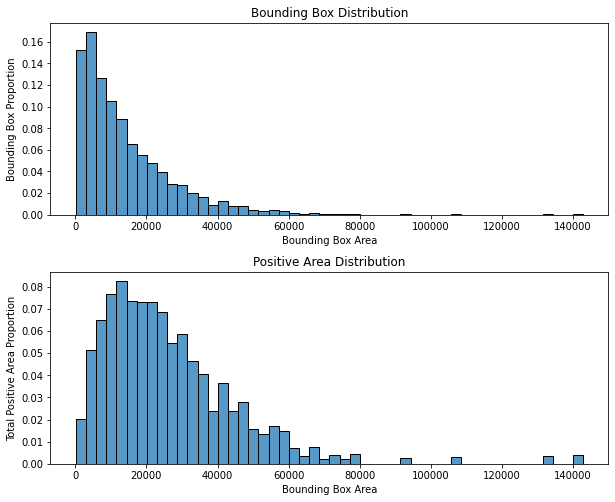

In [15]:
fig, ax = plt.subplots(2, figsize=(10,7))
"""
ax[0].set_title(f'Area Cumulative Distribution (Annotators: {0,4,5,6})')
y = np.cumsum(list(range(len(data))))/((len(data)+1)*len(data)/2)
sns.lineplot(x=sorted(data["area"])[::5],y=y[::5], ax=ax[0])
ax[0].set_xlabel('Area')
ax[0].set_ylabel('Cumulative Probability')
"""
ax[0].set_title('Bounding Box Distribution')
sns.histplot(x=data["area"], ax=ax[0], bins=50, stat="probability")
ax[0].set_xlabel('Bounding Box Area')
ax[0].set_ylabel('Bounding Box Proportion')

ax[1].set_title('Positive Area Distribution')
sns.histplot(x=data["area"], ax=ax[1], weights= data["area"],bins=50,stat="probability")
ax[1].set_xlabel('Bounding Box Area')
ax[1].set_ylabel('Total Positive Area Proportion')


for ax_i in ax:
    ax_i.sharex(ax[0])
fig.subplots_adjust(top=1, hspace=0.3)
plt.savefig('./figures/box_area_dist.png',bbox_inches='tight')
plt.show()

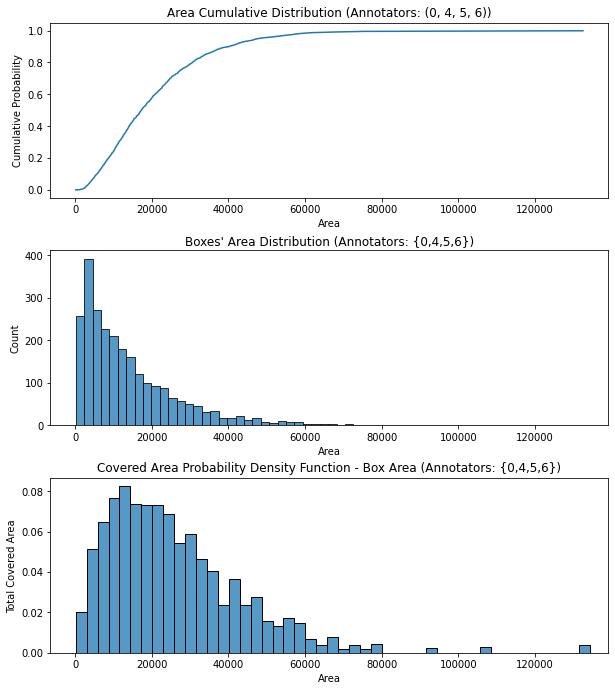

In [16]:
fig, ax = plt.subplots(3, figsize=(10,10))
ax[0].set_title(f'Area Cumulative Distribution (Annotators: {0,4,5,6})')
y = np.cumsum(list(range(len(data))))/((len(data)+1)*len(data)/2)
sns.lineplot(x=sorted(data["area"])[::5],y=y[::5], ax=ax[0])
ax[0].set_xlabel('Area')
ax[0].set_ylabel('Cumulative Probability')

ax[1].set_title('Boxes\' Area Distribution (Annotators: {0,4,5,6})')
sns.histplot(x=data["area"], ax=ax[1])
ax[1].set_xlabel('Area')

ax[2].set_title('Covered Area Probability Density Function - Box Area (Annotators: {0,4,5,6})')
sns.histplot(x=data["area"], ax=ax[2], weights= data["area"],bins=50,stat="probability")
ax[2].set_xlabel('Area')
ax[2].set_ylabel('Total Covered Area')

for ax_i in ax:
    ax_i.sharex(ax[0])
fig.subplots_adjust(top=1, hspace=0.3)
plt.show()

We might find useful to do two models:
 - One for small bounding boxes (that might then be useful to find greater grape clusters).
 - One for big clusters, that is able to find 
We are mainly interested in removing small bounding boxes, as they are the ones with highest probability of mistake.

In [17]:
num_bins=200
temp_data = data[data["annotator"].isin([0,4,5,6])]
bin_diff = 500#temp_data["area"].max()/num_bins
y_abs=temp_data["area"].groupby(temp_data["area"]//bin_diff).sum()
y_count=temp_data["area"].groupby(temp_data["area"]//bin_diff).size()
y_rel=y_abs/y_abs.sum()
y_rel.index=(bin_diff*y_rel.index).astype(int)
y_count.index=(bin_diff*y_rel.index).astype(int)
area_mask_dist = pd.DataFrame({
    "mask_density_dist": y_rel,
    "mask_cumulative_dist": y_rel.cumsum(),
    "boxes_density_dist": y_count.values/y_count.values.sum(),
    "boxes_cumulative_dist": y_count.values.cumsum()/y_count.values.sum()
})
area_mask_dist[area_mask_dist["mask_cumulative_dist"] < 0.4]

,mask_density_dist,mask_cumulative_dist,boxes_density_dist,boxes_cumulative_dist
area,,,,
0,0.000138,0.000138,0.006319,0.006319
500,0.001026,0.001164,0.018562,0.024882
1000,0.001928,0.003092,0.021327,0.046209
1500,0.004211,0.007303,0.033570,0.079779
2000,0.005620,0.012924,0.034755,0.114534
2500,0.007318,0.020242,0.037520,0.152054
3000,0.008722,0.028964,0.037915,0.189968
3500,0.009165,0.038128,0.034360,0.224329
4000,0.008826,0.046954,0.029226,0.253555


In [18]:
def plot_box(image_id, box, annotator=None, with_resize=False, title='', custom_ax=None):
    old_annotator_draw = data_holder.dataset.annotator_draw
    data_holder.dataset.annotator_draw = annotator
    image, target = get_item(data_holder, image_id)
    data_holder.dataset.annotator_draw = old_annotator_draw
    box_idxs = torch.where((torch.from_numpy(box) == target["boxes"]).sum(1) == 4)[0]
    if len(box_idxs) == 0:
        print(f"WARNING: {box} not found for image id {image_id}. Title: {title}")
        return
    box_idx = box_idxs[0].item()
    box = target["boxes"][box_idx].int()
    im = image[box[1]:box[3],box[0]:box[2]].numpy()
    if custom_ax is None:
        if with_resize:
            fig, ax = plt.subplots(1, 2, figsize=(10,25))
        else:
            fig, ax = plt.subplots(1, 1, figsize=(4,6))
            ax = [ax]
    else:
        ax=[custom_ax]
    ax[0].set_title(title)
    ax[0].imshow(im)
    if with_resize:
        image, target = get_item(data_holder, image_id,resize=True, min_size=MIN_SIZE, max_size=MAX_SIZE)
        box = target["boxes"][box_idx].int()
        im = image[box[1]:box[3],box[0]:box[2]].numpy()
        ax[1].set_title(title)
        ax[1].imshow(im)
    if custom_ax is None:
        plt.show()

In [19]:
d_sorted_area = data[data["annotator"].isin([0,4,5,6])].sort_values("area").reset_index(drop=True)

In [20]:
def plot_boxes_per_area_fig(areas=[1700,2500, 4200], n_per_box=5):
    fig, ax = plt.subplots(len(areas), n_per_box, figsize=(12,12))
    for j, area in enumerate(areas):
        area_idx = d_sorted_area[d_sorted_area["area"] > area].index[0]
        for i in range(n_per_box):
            box_columns = ["xmin", "ymin", "xmax", "ymax"]
            row = d_sorted_area.iloc[area_idx + i+3]
            image_id, box, area, ar = row["image_id"], row[box_columns].astype(np.int).values, row["area"], row["w"]/row["h"]
            plot_box(
                image_id,
                box,
                row["annotator"],
                title=f'Area: {area} | Annotator: {row["annotator"]}',
                custom_ax=ax[j][i]
            )
            ax[j][i].set_xticks([])
            ax[j][i].set_yticks([])
    plt.tight_layout()
    plt.savefig('./figures/small_boxes.png')
    plt.show()

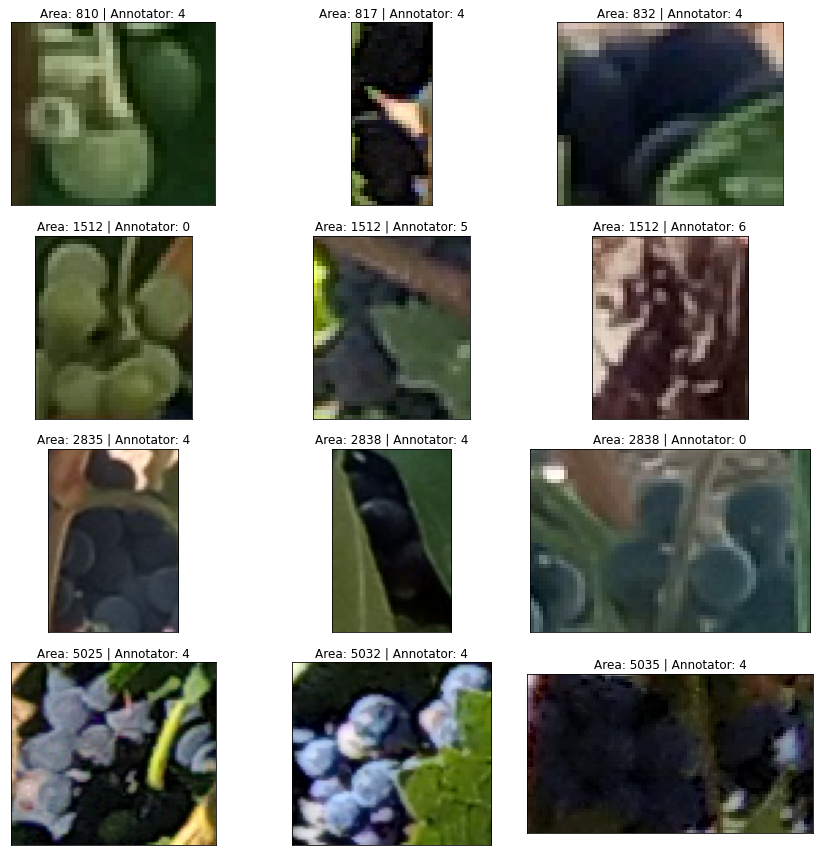

In [21]:
plot_boxes_per_area_fig(areas=[750, 1500,2800, 5000],n_per_box=3)